In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
import numpy as np
from folium.plugins import MarkerCluster
import requests
from shapely.geometry import shape
from folium.plugins import HeatMap
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

In [26]:
df = pd.read_csv('california_crimes.csv')
df.columns

/var/folders/_7/n11lkkv90h38g13gmy07jt840000gn/T/ipykernel_8196/292305385.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('california_crimes.csv')


Index(['ind_id', 'ind_definition', 'reportyear', 'race_eth_code',
       'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_fips',
       'county_name', 'region_code', 'region_name', 'strata_name_code',
       'strata_name', 'strata_level_name_code', 'strata_level_name',
       'numerator', 'denominator', 'rate', 'll_95ci', 'ul_95ci', 'se', 'rse',
       'ca_decile', 'ca_rr', 'dof_population', 'version'],
      dtype='object')

In [27]:
pd.set_option("display.max_columns", None)
df2=df[['reportyear','geoname','county_name','region_name','strata_level_name','numerator']]
df2.columns

Index(['reportyear', 'geoname', 'county_name', 'region_name',
       'strata_level_name', 'numerator'],
      dtype='object')

In [28]:
# Pivot crime types into separate columns
df_wide = df2.pivot_table(
    index=['reportyear', 'geoname', 'county_name', 'region_name'],
    columns='strata_level_name',
    values='numerator'
).reset_index()
df_wide.drop('Forcible rape', axis=1, inplace=True)
df_wide.head()
df_wide.columns

Index(['reportyear', 'geoname', 'county_name', 'region_name',
       'Aggravated assault', 'Murder and non-negligent manslaughter',
       'Robbery', 'Violent crime total'],
      dtype='object', name='strata_level_name')

# Choropleth Map (Map Visualization)

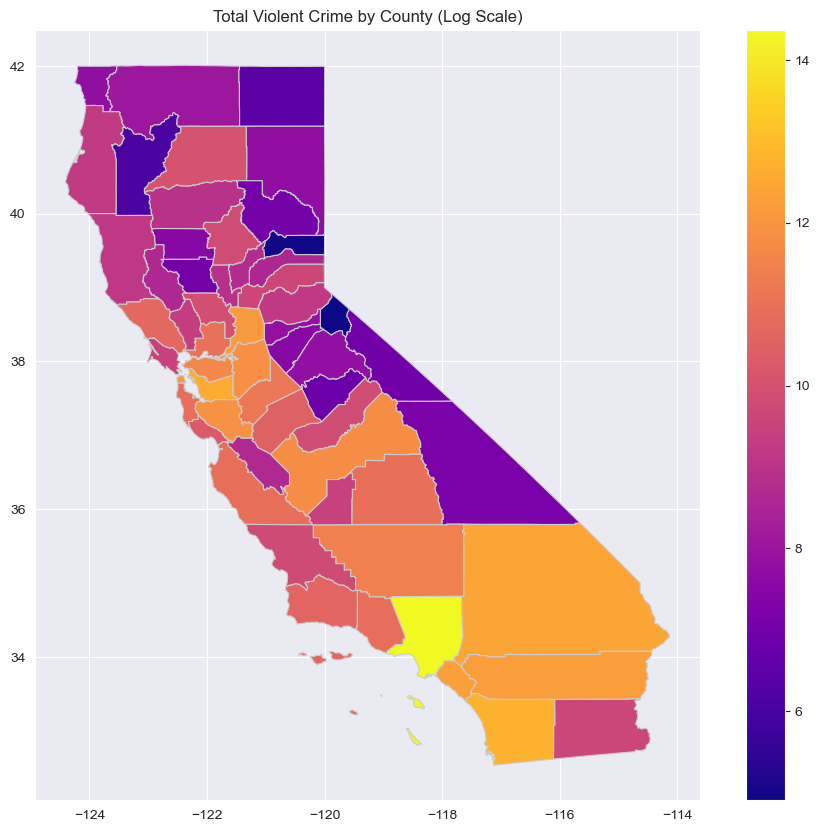

In [29]:
geo_json_url = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson'

counties_gdf = gpd.read_file(geo_json_url)
df_map = df_wide[['county_name','Violent crime total']].groupby('county_name').sum()
#df_map = df_wide[['county_name', 'Violent crime total']].copy()
df_map['log_total_violent'] = np.log1p(df_map['Violent crime total'])

merged_gdf = counties_gdf.merge(df_map, how='left', left_on='name', right_on='county_name')

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged_gdf.plot(
    column='log_total_violent',
    cmap='plasma',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
)
ax.set_title('Total Violent Crime by County (Log Scale)')
plt.show()

# Heatmap (Map Visualization --> Aggregation Visualization)

In [30]:
df = pd.read_csv('california_crimes.csv')

df2=df[['reportyear','geoname','county_name','region_name','strata_level_name','numerator']]

df_wide = df2.pivot_table(
    index=['reportyear', 'geoname', 'county_name', 'region_name'],
    columns='strata_level_name',
    values='numerator'
).reset_index()
df_wide.drop('Forcible rape', axis=1, inplace=True)

cities_geo_url = (
    "https://services3.arcgis.com/uknczv4rpevve42E/ArcGIS/rest/services/"
    "California_Cities_and_Identifiers_Blue_Version_view/FeatureServer/2/"
    "query?where=1%3D1&outFields=CENSUS_PLACE_NAME&f=geojson"
)

all_agvtd_aslt = df_wide.groupby('geoname', as_index=False)['Aggravated assault'].sum()

m = folium.Map(location=[37.0, -119.5], zoom_start=6)

cities_geo = requests.get(cities_geo_url).json()

centroid_map = {
    feature['properties']['CENSUS_PLACE_NAME']: shape(feature['geometry']).centroid
    for feature in cities_geo['features']
}

def normalize_city_name(name):
    return (
        name.replace(" city", "")
            .replace(" town", "")
            .replace(" CDP", "")
            .replace("'", "")
            .strip()
    )

all_agvtd_aslt['geoname_clean'] = all_agvtd_aslt['geoname'].apply(normalize_city_name)
centroid_map_clean = {normalize_city_name(k): v for k, v in centroid_map.items()}

heat_data = [
    [centroid_map_clean[geoname].y, centroid_map_clean[geoname].x, assault_count]
    for geoname, assault_count in zip(all_agvtd_aslt['geoname_clean'], all_agvtd_aslt['Aggravated assault'])
    if geoname in centroid_map_clean
]

HeatMap(heat_data, radius=15, blur=18, max_zoom=6).add_to(m)

# Add a layer control and save the map
folium.LayerControl().add_to(m)
m.save('aggravated_assault_heatmap.html')

/var/folders/_7/n11lkkv90h38g13gmy07jt840000gn/T/ipykernel_8196/1269953507.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('california_crimes.csv')


# Violin Plot

Text(0, 0.5, 'Log(Number of Incidents)')

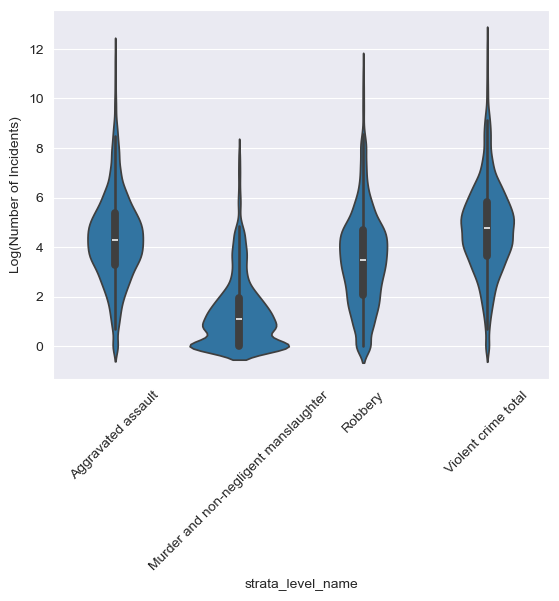

In [31]:
violin_data=df2.copy()
violin_data['log_numerator'] = np.log(violin_data['numerator'])
violin_data.drop(
    violin_data[violin_data['strata_level_name'].isin([
        'Forcible rape', 'Jurisdiction does not report'
    ])].index,
    inplace=True
)
sns.violinplot(x='strata_level_name', y='log_numerator', data=violin_data)
plt.xticks(rotation=45)
plt.ylabel('Log(Number of Incidents)')

# Continuous Scatter Plot

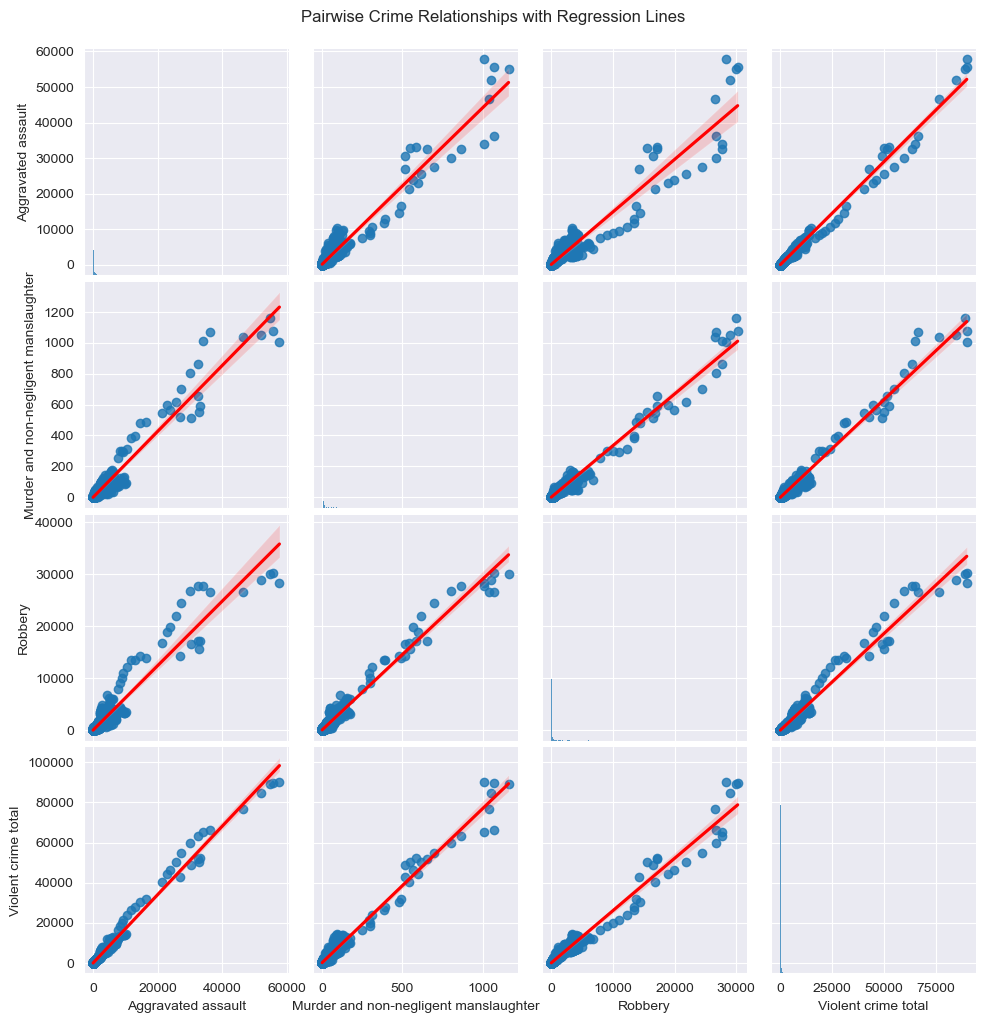

In [32]:
# Select your relevant columns
crime_cols = [
    'Aggravated assault',
    'Murder and non-negligent manslaughter',
    'Robbery',
    'Violent crime total'
]
df_log = df_wide[crime_cols].apply(np.log)
# Plot pairwise relationships with regression lines
sns.pairplot(df_wide[crime_cols], kind='reg', plot_kws={'line_kws': {'color': 'red'}})
plt.suptitle('Pairwise Crime Relationships with Regression Lines', y=1.02)
plt.show()

In [33]:
print('r = Correlation Coefficient. Measures the strength and direction of a linear relationship between two variables.')
print('r² = Coefficient of Determination. Tells you how much of the variance in one variable is explained by the other.\n')
for i, col1 in enumerate(crime_cols):
    for col2 in crime_cols[i+1:]:
        r = df_log[col1].corr(df_log[col2])
        r2 = r ** 2
        print(f"{col1} vs {col2}: r = {r:.3f}, r² = {r2:.3f}")

r = Correlation Coefficient. Measures the strength and direction of a linear relationship between two variables.
r² = Coefficient of Determination. Tells you how much of the variance in one variable is explained by the other.

Aggravated assault vs Murder and non-negligent manslaughter: r = 0.829, r² = 0.687
Aggravated assault vs Robbery: r = 0.883, r² = 0.779
Aggravated assault vs Violent crime total: r = 0.987, r² = 0.975
Murder and non-negligent manslaughter vs Robbery: r = 0.820, r² = 0.672
Murder and non-negligent manslaughter vs Violent crime total: r = 0.851, r² = 0.724
Robbery vs Violent crime total: r = 0.939, r² = 0.882


# Marker Cluster (Interactive Map Visualization)

In [34]:
df = pd.read_csv('california_crimes.csv')

crime_types = [
    'Aggravated assault',
    'Murder and non-negligent manslaughter',
    'Robbery',
    'Violent crime total'
]

df_filtered = df[df['strata_level_name'].isin(crime_types)]
county_data = (
    df_filtered
    .pivot_table(index='county_name', columns='strata_level_name', values='numerator', aggfunc='sum')
    .reset_index()
)

geo_json_url = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson'
counties_geo = requests.get(geo_json_url).json()

centroids = {
    feature['properties']['name']: shape(feature['geometry']).centroid
    for feature in counties_geo['features']
}

m = folium.Map(location=[37.0, -119.5], zoom_start=6)
marker_cluster = MarkerCluster().add_to(m)

for _, row in county_data.iterrows():
    county = row['county_name']
    if county in centroids:
        lat = centroids[county].y
        lon = centroids[county].x
        popup = folium.Popup(
            f"{county}<br>"
            f"Aggravated Assault: {row.get('Aggravated assault', 0):,}<br>"
            f"Murder: {row.get('Murder and non-negligent manslaughter', 0):,}<br>"
            f"Robbery: {row.get('Robbery', 0):,}<br>"
            f"Violent Crime Total: {row.get('Violent crime total', 0):,}"
        )
        tooltip = county
        folium.Marker(
            location=[lat, lon],
            popup=popup,
            tooltip=tooltip
        ).add_to(marker_cluster)

m.save('county_cluster_map.html')

/var/folders/_7/n11lkkv90h38g13gmy07jt840000gn/T/ipykernel_8196/2181423332.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('california_crimes.csv')


# Time-series visualizations with scrubbing (Interactive Visualization)

In [3]:
df = pd.read_csv('california_crimes.csv', low_memory=False)

crime_types = [
    'Aggravated assault',
    'Murder and non-negligent manslaughter',
    'Robbery',
    'Violent crime total'
]
county_list = sorted(df['county_name'].dropna().unique().tolist())

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='county-dropdown',
        options=[{'label': c, 'value': c} for c in county_list],
        value=county_list[0] if county_list else None
    ),
    dcc.Graph(id='time-series')
])

@app.callback(
    Output('time-series', 'figure'),
    Input('county-dropdown', 'value')
)

def update_figure(selected_county):
    df_filtered = df[(df['county_name'] == selected_county) & (df['strata_level_name'].isin(crime_types))]
    df_grouped = df_filtered.groupby(
        ['reportyear', 'strata_level_name'], as_index=False
    )['numerator'].sum()
    fig = px.bar(
        df_grouped,
        x='strata_level_name',
        y='numerator',
        animation_frame='reportyear',
        color='strata_level_name',
        title=f'Crime Trends in {selected_county}',
        labels={'numerator': 'Total', 'strata_level_name': 'Crime Type', 'reportyear': 'Year'}
    )
    fig.update_layout(
        transition={'duration': 300}
    )

    return fig

if __name__ == '__main__':
    app.run(debug=True)